Deep Learning
=============

Assignment 6
------------

After training a skip-gram model in `5_word2vec.ipynb`, the goal of this notebook is to train a LSTM character model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import random
import string
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from time import time

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified %s' % filename)
    else:
        print(statinfo.st_size)
        raise Exception(
            'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


In [3]:
def read_data(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return tf.compat.as_str(f.read(name))
    f.close()

text = read_data(filename)
print('Data size %d' % len(text))

Data size 100000000


In [4]:
print(text[:63])
print(text[-63:])

 anarchism originated as a term of abuse first used against ear
extensively excavated in one nine six three one nine six five b


In [5]:
text = text.strip()
len(text)

99999999

In [6]:
text[1002]

' '

Create a small validation set.

In [5]:
valid_text = text[:1003].strip()  # to monitor performance during training
valid_size = len(valid_text)
train_text = text[1003:].strip()
train_size = len(train_text)

print(train_size, train_text[:64])
print(valid_size, valid_text[:64])

99998996 anarchists advocate social relations based upon voluntary associ
1002 anarchism originated as a term of abuse first used against early


Utility functions to map characters to vocabulary IDs and back.

In [6]:
vocabulary_size = len(string.ascii_lowercase) + 1 # [a-z] + ' '
first_letter = ord(string.ascii_lowercase[0])

def char2id(char):
    if char in string.ascii_lowercase:
        return ord(char) - first_letter + 1
    elif char == ' ':
        return 0
    else:
        print('Unexpected character: %s' % char)
    return 0

def id2char(dictid):
    if dictid > 0:
        return chr(dictid + first_letter - 1)
    else:
        return ' '

print(char2id('a'), char2id('z'), char2id(' '), char2id('ï'))
print(id2char(1), id2char(26), id2char(0))

Unexpected character: ï
1 26 0 0
a z  


Function to generate a training batch for the LSTM model.

In [7]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 27 ndarray here.
    In a batch, each char is taken from each segment.
    With _next_batch(), will keep taking next char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size) ]
        self._last_batch = self._next_batch()  # the last batch is to be predicted
  
    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, char2id(self._text[self._cursor[b]])] = 1.0
            self._cursor[b] = (self._cursor[b] + 1) % self._text_size
        return batch
  
    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2char(c) for c in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['anarchists ', ' military g', 'ia arches n', 'eys and mon', 'ied urraca ', 'and richard', 'd liturgica', 'pened for p', ' from the n', 'ation took ', 'york other ', 'oeing seven', 'sted with a', ' has probab', ' made to re', 'who receive', 'significant', 'erce critic', ' six eight ', 'totle s unc', 'can be lost', ' intracellu', ' of the siz', 'o pass him ', 'rtain drugs', 't will take', 'nvince the ', 'told him to', 'ign and bar', ' side stand', ' texts such', 'pitalize on', 'plicate of ', 'nn es d hiv', 'january eig', ' zero the l', 'theories cl', 'instance th', 'ensional an', ' holy mormo', 'support or ', ' still disa', 'cillating s', 'ght subtype', 'taly langua', 'e tower com', 'oma press o', 'ise linux s', 'ecomes the ', 'n a nazi co', 'fabian soci', 'y to relati', 'rman networ', ' emperor hi', ' in politic', 'o latin mos', 'isky risker', 'clopedic ov', 'e the air c', 'ing from ac', 't grid cent', 'ns more tha', 'al of devot', 'ave made su']
[' advocate s', 'governments', 'nationa

In [8]:
## Helper functions
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10  # avoid -log(p) prone to infinity
    return np.sum(labels * -np.log(predictions)) / labels.shape[0]

def sample_distribution(distribution):
    """Sample one element from a probability distribution assumed to be an 
    normalized array (sum to 1).
    """
    r = random.uniform(0, 1)
    s = 0
    for i in range(len(distribution)):
        s += distribution[i]
        if s >= r:
            return i
    return len(distribution) - 1

def sample(prediction):
    """Turn a (column) prediction into 1-hot encoded samples."""
    p = np.zeros(shape=[1, vocabulary_size], dtype=np.float)
    p[0, sample_distribution(prediction[0])] = 1.0
    return p

def random_distribution():
    """Generate a random column of probabilities."""
    b = np.random.uniform(0.0, 1.0, size=[1, vocabulary_size])
    return b/np.sum(b, 1)[:,None]

def weight_init(n_in, n_out, width=0.1):
    return tf.Variable(tf.truncated_normal([n_in, n_out], -width, width))

def bias_init(num_nodes):
    return tf.Variable(tf.zeros([1, num_nodes]))

Simple LSTM Model.

In [11]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
    
    # Parameters:
    # Input gate: input, previous output, and bias.
    ix = weight_init(vocabulary_size, num_nodes)
    im = weight_init(num_nodes, num_nodes)
    ib = bias_init(num_nodes)
    # Forget gate: input, previous output, and bias.
    fx = weight_init(vocabulary_size, num_nodes)
    fm = weight_init(num_nodes, num_nodes)
    fb = bias_init(num_nodes)
    # Memory cell: input, state and bias.                             
    cx = weight_init(vocabulary_size, num_nodes)
    cm = weight_init(num_nodes, num_nodes)
    cb = bias_init(num_nodes)
    # Output gate: input, previous output, and bias.
    ox = weight_init(vocabulary_size, num_nodes)
    om = weight_init(num_nodes, num_nodes)
    ob = bias_init(num_nodes)
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = weight_init(num_nodes, vocabulary_size)
    b = bias_init(vocabulary_size)

    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
        forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
        update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier.
        #logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
        logits = tf.matmul(tf.concat(0, outputs), w) + b
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits, tf.concat(0, train_labels)))

    # Optimizer.
    # note: 
    #   tf.train.optimizer.minimize() same as 
    #   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)  
    
    # Predictions.
    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])  # one sample character
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [12]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            
            perp_loss = float(np.exp(mean_loss))
            print('Minibatch perplexity (from avg loss): %.2f' % perp_loss)
            perp_loss_log.append(perp_loss)
            mean_loss = 0
            
            labels = np.concatenate(list(batches)[1:])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity (from preds-labels): %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79):
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized. Start training...
Average loss at step 0: 3.296984, learning rate: 10.000000
Minibatch perplexity (from avg loss): 27.03
Minibatch perplexity (from preds-labels): 27.03
 opohajdmpemvohwmdwant ctlktgqtut  livigmleclfrr zhnts grfo origeozofieydebzoibk
ir i w tcooeauhptkcabchd uopeoboxsxwxpeohiiyphrnadehcnjw tmt qoapazeurceklapkhle
y vn la ilulonewzmtfafkb n nogjnmovowumia  pexh absu irwihucgel arh gtnsrb mqfra
qiytqwvcapaggmrsjthfmcnjto faudemv oe sebvsljozaulzdjtuzvliphdcjipilb ro nsliah 
rmfj ux  etsho cbi n yi b gsef jqxku eiaoiydbpoaorir abraer arfpwbhrjcs runr sdk
Validation set perplexity: 20.21
Average loss at step 100: 2.596293, learning rate: 10.000000
Minibatch perplexity (from avg loss): 13.41
Minibatch perplexity (from preds-labels): 11.31
Validation set perplexity: 10.43
Average loss at step 200: 2.247800, learning rate: 10.000000
Minibatch perplexity (from avg loss): 9.47
Minibatch perplexity (from preds-labels): 8.58
Validation set perplexity: 8.65
Average los

In [37]:
def plot_log(loss_log, perp_log, val_perp_log):
    pylab.style.use('ggplot')
    f, (ax1, ax2) = pylab.subplots(1, 2, figsize=(14,6))
    ax1.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='batch_perp')
    ax1.plot(summary_frequency*(np.arange(len(val_perp_log))+1), val_perp_log, 'r-', label='val_perp')
    ax1.set_xlabel('Training step')
    ax1.set_ylabel('Perplexity')
    ax1.legend(loc='best')

    line1 = ax2.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='batch_perp')
    ax2.set_xlabel('Training step')
    ax2.set_ylabel('Perplexity')
    ax3 = ax2.twinx()
    line2 = ax3.plot(summary_frequency*(np.arange(len(loss_log))+1), loss_log, 'r-', label='batch_loss')
    ax3.set_ylabel('Loss')
    lines = line1 + line2
    labels = [line.get_label() for line in lines]
    ax2.legend(lines, labels, loc='best')
    
    pylab.show()

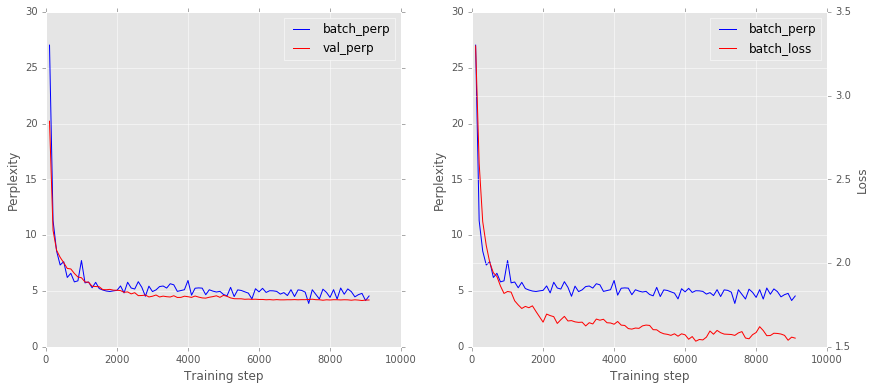

In [15]:
plot_log(loss_log, perp_log, val_perp_log)  # by SGD optimizer

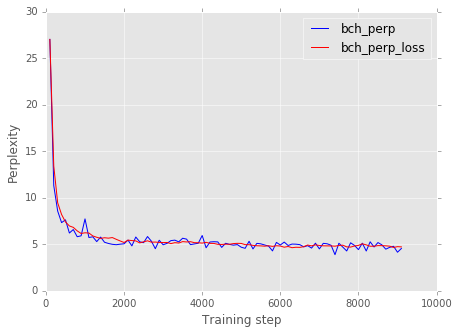

In [16]:
pylab.style.use('ggplot')
f, ax = pylab.subplots(1, 1, figsize=(7,5))
ax.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='bch_perp')
ax.plot(summary_frequency*(np.arange(len(perp_loss_log))+1), perp_loss_log, 'r-', label='bch_perp_loss')
ax.set_xlabel('Training step')
ax.set_ylabel('Perplexity')
ax.legend(loc='best')

Encapsulate to an OO version

In [113]:
class LSTMcell():
    
    def __init__(self, input_dim, num_nodes):
        # Input gate: input, previous output, and bias.
        self.ix = weight_init(input_dim, num_nodes)
        self.im = weight_init(num_nodes, num_nodes)
        self.ib = bias_init(num_nodes)
        # Forget gate: input, previous output, and bias.
        self.fx = weight_init(input_dim, num_nodes)
        self.fm = weight_init(num_nodes, num_nodes)
        self.fb = bias_init(num_nodes)
        # Memory cell: input, state and bias.                             
        self.cx = weight_init(input_dim, num_nodes)
        self.cm = weight_init(num_nodes, num_nodes)
        self.cb = bias_init(num_nodes)
        # Output gate: input, previous output, and bias.
        self.ox = weight_init(input_dim, num_nodes)
        self.om = weight_init(num_nodes, num_nodes)
        self.ob = bias_init(num_nodes)
        # Variables saving state across unrollings.
        self.saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
        self.saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
        # Variables saving state for predict/generate phase.
        self.saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
        self.saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
        # Reset for-sample cell state
        self.reset_sample_state = tf.group(
            self.saved_sample_output.assign(tf.zeros([1, num_nodes])),
            self.saved_sample_state.assign(tf.zeros([1, num_nodes])))
    
    
    def memorize(self, i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, self.ix) + tf.matmul(o, self.im) + self.ib)
        forget_gate = tf.sigmoid(tf.matmul(i, self.fx) + tf.matmul(o, self.fm) + self.fb)
        update = tf.matmul(i, self.cx) + tf.matmul(o, self.cm) + self.cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, self.ox) + tf.matmul(o, self.om) + self.ob)
        
        return output_gate * tf.tanh(state), state
    
    
    def forward_pass(self, inputs, saved_output=None, saved_state=None):
        # Unrolled LSTM loop.
        self.outputs = list()
        if saved_output and saved_state:
            self.saved_output = saved_output
            self.saved_state = saved_state
        output = self.saved_output
        state = self.saved_state
        # forward propagate into LSTM cells
        for inp in inputs:
            output, state = self.memorize(inp, output, state)
            self.outputs.append(output)
        self.saved_output = output
        self.saved_state = state
        

    def predict(self, _input, saved_sample_output=None, saved_sample_state=None):
        if saved_sample_output and saved_sample_state:
            self.saved_sample_output = saved_sample_output
            self.saved_sample_state = saved_sample_state
        output = self.saved_sample_output
        state = self.saved_sample_state
        return self.memorize(_input, output, state)
    
    
    def resetState(self):
        self.saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
        self.saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)

In [114]:
class Softmax():
    
    def __init__(self, input_dim, labels):
        self.w = weight_init(input_dim, labels)
        self.b = bias_init(labels)
    
    def forward_pass(self, inputs):
        self.logits = tf.matmul(tf.concat(0, inputs), self.w) + self.b
    
    def predict(self, _input):
        return tf.nn.softmax(tf.matmul(_input, self.w) + self.b)

In [121]:
class LSTM_net():
    
    def __init__(self, layers):
        self.layers = layers
    
    def forwardPropagate(self, inputs):
        self.layers[0].forward_pass(inputs)
        for j in range(1, len(self.layers)):
            self.layers[j].forward_pass(self.layers[j-1].outputs)
    
    def predict(self, _input):
        o, s = self.layers[0].predict(_input)
        for j in range(1, len(self.layers)-1):
            with tf.control_dependencies([self.layers[j-1].saved_sample_output.assign(o),
                                          self.layers[j-1].saved_sample_state.assign(s)]):
                o, s = self.layers[j].predict(o)
        with tf.control_dependencies([self.layers[-2].saved_sample_output.assign(o),
                                      self.layers[-2].saved_sample_state.assign(s)]):
            return self.layers[-1].predict(o)
            
    def reset_sample_state(self):
        for j in range(len(self.layers)-1):
            self.layers[j].reset_sample_state.run()
        
    def reset_state(self):
        for j in range(len(self.layers)-1):
            self.layers[j].resetState()

In [127]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():
    
    # Parameters:
    lstm_net = LSTM_net([LSTMcell(vocabulary_size, num_nodes), 
                         Softmax(num_nodes, vocabulary_size)])

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    # Unrolled LSTM loop.
    lstm_net.forwardPropagate(train_inputs)

    # Classifier.
    logits = lstm_net.layers[-1].logits
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits, tf.concat(0, train_labels)))

    # Optimizer.
    # note: 
    #   tf.train.optimizer.minimize() same as 
    #   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)
    
    # Predictions.
    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch_size=1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])  # one sample character
    sample_prediction = lstm_net.predict(sample_input)

In [128]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f' % (step, mean_loss))
            loss_log.append(mean_loss)
            
            perp_loss = float(np.exp(mean_loss))
            print('Minibatch perplexity (from avg loss): %.2f' % perp_loss)
            perp_loss_log.append(perp_loss)
            mean_loss = 0
            
            labels = np.concatenate(list(batches)[1:])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity (from preds-labels): %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    lstm_net.reset_sample_state()
                    for _ in range(79):
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 80)
            
            # Measure validation set perplexity.
            lstm_net.reset_sample_state()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0, 'seconds.')

Initialized. Start training...
Average loss at step 0: 3.298741
Minibatch perplexity (from avg loss): 27.08
Minibatch perplexity (from preds-labels): 27.08
vgfrluidfk isdmbzin ygmfpfaolrsvfomnfsrioojyrdha ln rgpx cuhofex dup faiuitiu zs
rfmp   nneasecf wqb iapup o wafia vchmiedtm tgcpd gx ljweimqk xrbwoyorteo nrv ew
qtiei eatfie mhea szs ypdraacygad rei ohh b naivtjqxoa uis uhqslluiietaxqns oeem
xepx woaoucaewxlxejvg pexjeurgishyvip  nttc  mvinozker acfwo ie emxz eun t l frg
bxwirdspgikof ti iu s inecacpcmymdwie tsccofjia lnmtpn s fk hecghxsotwtvr ey crc
Validation set perplexity: 20.13
Average loss at step 100: 2.625027
Minibatch perplexity (from avg loss): 13.80
Minibatch perplexity (from preds-labels): 11.85
Validation set perplexity: 11.81
Average loss at step 200: 2.336070
Minibatch perplexity (from avg loss): 10.34
Minibatch perplexity (from preds-labels): 8.95
Validation set perplexity: 8.99
Average loss at step 300: 2.210509
Minibatch perplexity (from avg loss): 9.12
Minibatch 

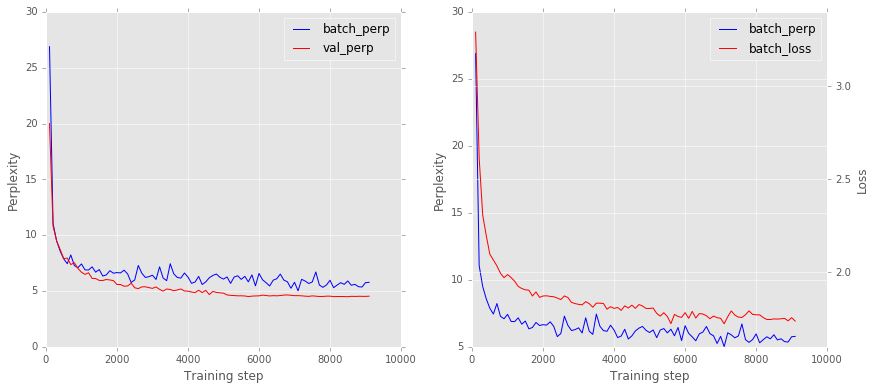

In [84]:
plot_log(loss_log, perp_log, val_perp_log)  # by SGD optimizer

---
Problem 1
---------

You might have noticed that the definition of the LSTM cell involves 4 matrix multiplications with the input, and 4 matrix multiplications with the output. Simplify the expression by using a single matrix multiply for each, and variables that are 4 times larger.

---

In [81]:
num_nodes = 64

graph = tf.Graph()
with graph.as_default():

    # Parameters:
    # All param variables: input gate, forget gate, memory cell, output gate
    wx = weight_init(vocabulary_size, 4*num_nodes)
    wm = weight_init(num_nodes, 4*num_nodes)
    wb = bias_init(4*num_nodes)
    # Variables saving state across unrollings.
    saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
    # Classifier weights and biases.
    w = weight_init(num_nodes, vocabulary_size)
    b = bias_init(vocabulary_size)

    # Definition of the cell computation.
    def lstm_cell(i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates.
        * tf.slice ref:  https://www.tensorflow.org/api_docs/python/tf/slice
        * tf.slice(tensor, start_element, shape_to_slice)
        """
        input_output = tf.sigmoid(tf.matmul(i, wx) + tf.matmul(o, wm) + wb)
        forget_gate = tf.slice(input_output, [0, 0], [tf.shape(i)[0], num_nodes])
        input_gate = tf.slice(input_output, [0, num_nodes], [tf.shape(i)[0], num_nodes])
        update = tf.slice(input_output, [0, 2*num_nodes], [tf.shape(i)[0], num_nodes])
        output_gate = tf.slice(input_output, [0, 3*num_nodes], [tf.shape(i)[0], num_nodes])
        state = forget_gate * state + input_gate * tf.tanh(update)
        return output_gate * tf.tanh(state), state

    # Input data.
    train_data = list()
    for _ in range(num_unrollings + 1):
        train_data.append(
            tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
    train_inputs = train_data[:num_unrollings]
    train_labels = train_data[1:]  # labels are inputs shifted by one time step.

    # Unrolled LSTM loop.
    outputs = list()
    output = saved_output
    state = saved_state
    for i in train_inputs:
        output, state = lstm_cell(i, output, state)
        outputs.append(output)

    # State saving across unrollings.
    with tf.control_dependencies([saved_output.assign(output),
                                  saved_state.assign(state)]):
        # Classifier.
        #logits = tf.nn.xw_plus_b(tf.concat(0, outputs), w, b)
        logits = tf.matmul(tf.concat(0, outputs), w) + b
        loss = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(
                logits, tf.concat(0, train_labels)))

    # Optimizer.
    # note: 
    #   tf.train.optimizer.minimize() same as 
    #   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(
        10.0, global_step, 5000, 0.1, staircase=True)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    gradients, v = zip(*optimizer.compute_gradients(loss))
    gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
    optimizer = optimizer.apply_gradients(
        zip(gradients, v), global_step=global_step)  

    # Predictions.
    train_prediction = tf.nn.softmax(logits)

    # Sampling and validation eval: batch 1, no unrolling.
    sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])  # one sample character
    saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
    saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
    reset_sample_state = tf.group(
        saved_sample_output.assign(tf.zeros([1, num_nodes])),
        saved_sample_state.assign(tf.zeros([1, num_nodes])))
    sample_output, sample_state = lstm_cell(
        sample_input, saved_sample_output, saved_sample_state)
    with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                  saved_sample_state.assign(sample_state)]):
        sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [82]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(list(batches)[1:])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 80)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(79):
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 80)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized
Average loss at step 0: 3.300226 learning rate: 10.000000
Minibatch perplexity: 27.12
ispkb u rsjlw xema nmptutugl tyan  lbyt   li  gwetxbg ay chonjeybs eb rahet    t
ccrmatentworiiqntp s  bcapdv cy nwzqbuazqu bacsw ci kagtfnnexg vty  ieuel m eakc
jmwqbxstey  gtxmalee hlkveentwtgo r rfedmhyhfuqe nkhzeh  c eet cib air    decr d
nyiaogtww  bdutceud nsogm izesoqdeg  kckqmiryfdj itmtnfrntt fun ta ikaqjhiewvliy
xk e y  vgcre miei rllnpsdjieidoee fht smnb  d  jdvboyin  hed ujo  isrtxcyoli vk
Validation set perplexity: 19.72
Average loss at step 100: 2.851603 learning rate: 10.000000
Minibatch perplexity: 15.49
Validation set perplexity: 15.22
Average loss at step 200: 2.674142 learning rate: 10.000000
Minibatch perplexity: 13.48
Validation set perplexity: 13.75
Average loss at step 300: 2.504180 learning rate: 10.000000
Minibatch perplexity: 11.35
Validation set perplexity: 11.69
Average loss at step 400: 2.422899 learning rate: 10.000000
Minibatch perplexity: 10.43
Validation se

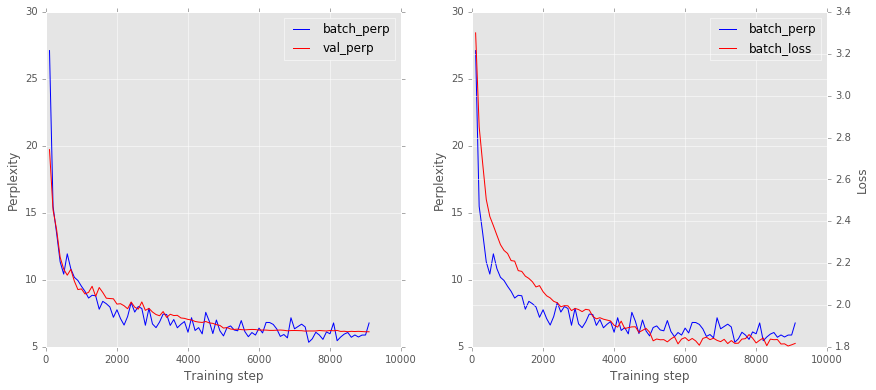

In [83]:
plot_log(loss_log, perp_log, val_perp_log)

---
Problem 2
---------

We want to train a LSTM over bigrams, that is pairs of consecutive characters like 'ab' instead of single characters like 'a'. Since the number of possible bigrams is large, feeding them directly to the LSTM using 1-hot encodings will lead to a very sparse representation that is very wasteful computationally.

a- Introduce an embedding lookup on the inputs, and feed the embeddings to the LSTM cell instead of the inputs themselves.

b- Write a bigram-based LSTM, modeled on the character LSTM above.

c- Introduce Dropout. For best practices on how to use Dropout in LSTMs, refer to this [article](http://arxiv.org/abs/1409.2329).

---

#### Here we start from (b), bigram-based LSTM.

In [43]:
chars = sorted(list(set(text)))
print(chars)

[' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Create bi-characters to vocabulary IDs mapping.

In [44]:
# id-char mapping
id2bichar = [c1+c2 for c1 in chars for c2 in chars]
bichar2id = {c:i for i, c in enumerate(id2bichar)}
vocabulary_size = len(id2bichar)

print(bichar2id['ab'], bichar2id['sz'], bichar2id[' a'])
print(id2bichar[1], id2bichar[26], id2bichar[102])

29 539 1
 a  z cu


Function to generate a training batch for the LSTM model.

In [120]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 27 ndarray here.
    In a batch, each char is taken from each segment.
    With _next_batch(), will keep taking next char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size) ]
        self._last_batch = self._next_batch()  # the last batch is to be predicted

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = np.zeros(shape=(self._batch_size, vocabulary_size), dtype=np.float)
        for b in range(self._batch_size):
            batch[b, bichar2id[ self._text[self._cursor[b]] + self._text[self._cursor[b]+1] ]] = 1.0
            self._cursor[b] = (self._cursor[b] + 2) % self._text_size  # 2 for bi-gram
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2bichar[cc] for cc in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * batches[0].shape[0]
    for b in batches:
        s = [''.join(x) for x in zip(s, characters(b))]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchists advocat', 'when military governme', 'lleria arches national', ' abbeys and monasterie', 'married urraca princes', 'hel and richard baer h', 'y and liturgical langu', 'ay opened for passenge', 'tion from the national', 'migration took place d', 'new york other well kn', 'he boeing seven six se', 'e listed with a gloss ', 'eber has probably been', 'o be made to recognize', 'yer who received the f', 'ore significant than i', 'a fierce critic of the', ' two six eight in sign', 'aristotle s uncaused c', 'ity can be lost as in ', ' and intracellular ice', 'tion of the size of th', 'dy to pass him a stick', 'f certain drugs confus', 'at it will take to com', 'e convince the priest ', 'ent told him to name i', 'ampaign and barred att', 'rver side standard for', 'ious texts such as eso', 'o capitalize on the gr', 'a duplicate of the ori', 'gh ann es d hiver one ', 'ine january eight marc', 'ross zero the lead cha', 'cal theories classical', 'ast instance the non g', ' dimension

In [121]:
## Without embedding layer

num_nodes = 64

# Parameters:
# Input gate: input, previous output, and bias.
ix = weight_init(vocabulary_size, num_nodes)
im = weight_init(num_nodes, num_nodes)
ib = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx = weight_init(vocabulary_size, num_nodes)
fm = weight_init(num_nodes, num_nodes)
fb = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx = weight_init(vocabulary_size, num_nodes)
cm = weight_init(num_nodes, num_nodes)
cb = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox = weight_init(vocabulary_size, num_nodes)
om = weight_init(num_nodes, num_nodes)
ob = bias_init(num_nodes)
# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
# Classifier weights and biases.
w = weight_init(num_nodes, vocabulary_size)
b = bias_init(vocabulary_size)

# Definition of the cell computation.
def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

# Input data.
train_data = list()
for _ in range(num_unrollings + 1):
    train_data.append(
        tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]))
train_inputs = train_data[:num_unrollings]
train_labels = train_data[1:]  # labels are inputs shifted by one time step.

# Unrolled LSTM loop.
outputs = list()
output = saved_output
state = saved_state
for i in train_inputs:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.matmul(tf.concat(0, outputs), w) + b
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits, tf.concat(0, train_labels)))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
train_prediction = tf.nn.softmax(logits)

# Sampling and validation eval: batch 1, no unrolling.
sample_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])  # one sample character
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output, sample_state = lstm_cell(
    sample_input, saved_sample_output, saved_sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [122]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(list(batches)[1:])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 100)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(49):
                        prediction = sample_prediction.eval({sample_input: feed})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 100)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, b[1])
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized. Start training...
Average loss at step 0: 6.591803, learning rate: 10.000000
Minibatch perplexity: 729.09
hjjverhutdtlwgcsvnde ymhmtjnychqzxmfove rgrxxoortuumlnusaeuepqtoxhji a nlsylaanuzdwjydukzkqpmlcleiqs
dqepyocazdmxcjvnuxurhrlmqkwraaavzzigwsbpjtkncs yqojanjctmkqpxlrsakuimlojgmglai exqxfqgvhdpo eanczzsx
yg xpxgwhhavegekpdghzdjbqtdcdbsbcbzmimkeduwdaysrawbbrssyfkmueph qoigtxgvioffyyusplnaskssbyodnkvgkktp
kzdmgaikxvepxyedpgnd ujidma uvtkwrwdafyvucwt onbiepluozggd oqcccinyaqewfrtnzw yxcabnmarbgkft xlnzvky
opuhcgnpzlgxzoawtcdwiruahlixktvqhtzus ukzttbc akhezbdq ezgedavpdnfrbarndgexpnnwwpcassqzinaxp alvdx g
Validation set perplexity: 670.37
Average loss at step 100: 5.425503, learning rate: 10.000000
Minibatch perplexity: 180.28
Validation set perplexity: 171.95
Average loss at step 200: 5.071930, learning rate: 10.000000
Minibatch perplexity: 146.23
Validation set perplexity: 147.79
Average loss at step 300: 4.722476, learning rate: 10.000000
Minibatch perplexity: 101.45
Vali

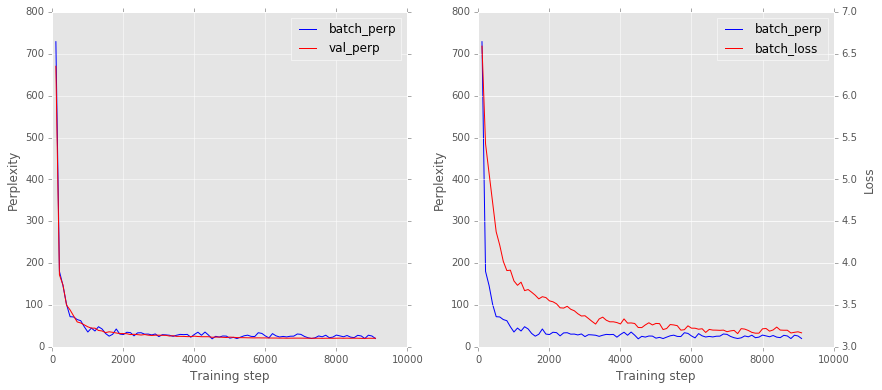

In [123]:
plot_log(loss_log, perp_log, val_perp_log)

#### Then try (a). Add an embedding layer

In [25]:
def batch2array(batch_list):
    batch = np.zeros(shape=(len(batch_list), vocabulary_size), dtype=np.float32)
    for i in xrange(len(batch_list)):
        batch[i, batch_list[i]] = 1
    return batch

In [124]:
## Set number of time step for unrolled net AND BatchGenerator for mini-batch training
batch_size = 64
num_unrollings = 10  # number of time step in recurrent net

class BatchGenerator(object):
    """Start with separating text data to segments with batch_size, e.g. 64 segments here.
    A batch contains an array with [batch_size x vocab_size], e.g. 64 x 27 ndarray here.
    In a batch, each char is taken from each segment.
    With _next_batch(), will keep taking next char in each segment, and next, and next...
    With next(), will collect num_unrollings batches as data input for recurrent net.
    """
    def __init__(self, text, batch_size, num_unrollings):
        self._text = text
        self._text_size = len(text)
        self._batch_size = batch_size
        self._num_unrollings = num_unrollings
        segment = self._text_size // batch_size
        self._cursor = [ offset * segment for offset in range(batch_size) ]
        self._last_batch = self._next_batch()  # the last batch is to be predicted

    def _next_batch(self):
        """Generate a single batch from the current cursor position in the data."""
        batch = []
        for b in range(self._batch_size):
            batch.append(bichar2id[ self._text[self._cursor[b]] + self._text[self._cursor[b]+1] ])
            self._cursor[b] = (self._cursor[b] + 2) % self._text_size  # 2 for bi-gram
        return batch

    def next(self):
        """Generate the next array of batches from the data. The array consists of
        the last batch of the previous array, followed by num_unrollings new ones.
        """
        batches = [self._last_batch]
        for step in range(self._num_unrollings):
            batches.append(self._next_batch())
        self._last_batch = batches[-1]
        return batches

def characters(probabilities):
    """Turn a 1-hot encoding or a probability distribution over the possible
    characters back into its (most likely) character representation."""
    return [id2bichar[cc] for cc in np.argmax(probabilities, 1)]

def batches2string(batches):
    """Convert a sequence of batches back into their (most likely) string
    representation."""
    s = [''] * len(batches[0])
    for b in batches:
        bichars = [id2bichar[i] for i in b]
        s = [''.join(x) for x in zip(s, bichars)]
    return s

train_batches = BatchGenerator(train_text, batch_size, num_unrollings)
valid_batches = BatchGenerator(valid_text, 1, 1)

print(batches2string(train_batches.next()))
print(batches2string(train_batches.next()))
print(batches2string(valid_batches.next()))
print(batches2string(valid_batches.next()))

['ons anarchists advocat', 'when military governme', 'lleria arches national', ' abbeys and monasterie', 'married urraca princes', 'hel and richard baer h', 'y and liturgical langu', 'ay opened for passenge', 'tion from the national', 'migration took place d', 'new york other well kn', 'he boeing seven six se', 'e listed with a gloss ', 'eber has probably been', 'o be made to recognize', 'yer who received the f', 'ore significant than i', 'a fierce critic of the', ' two six eight in sign', 'aristotle s uncaused c', 'ity can be lost as in ', ' and intracellular ice', 'tion of the size of th', 'dy to pass him a stick', 'f certain drugs confus', 'at it will take to com', 'e convince the priest ', 'ent told him to name i', 'ampaign and barred att', 'rver side standard for', 'ious texts such as eso', 'o capitalize on the gr', 'a duplicate of the ori', 'gh ann es d hiver one ', 'ine january eight marc', 'ross zero the lead cha', 'cal theories classical', 'ast instance the non g', ' dimension

In [126]:
## With embedding layer, no sparsity handling

num_nodes = 64
embedding_dim = 32

# Parameters:
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
# Input gate: input, previous output, and bias.
ix = weight_init(embedding_dim, num_nodes)
im = weight_init(num_nodes, num_nodes)
ib = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx = weight_init(embedding_dim, num_nodes)
fm = weight_init(num_nodes, num_nodes)
fb = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx = weight_init(embedding_dim, num_nodes)
cm = weight_init(num_nodes, num_nodes)
cb = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox = weight_init(embedding_dim, num_nodes)
om = weight_init(num_nodes, num_nodes)
ob = bias_init(num_nodes)
# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
# Classifier weights and biases.
w = weight_init(num_nodes, vocabulary_size)
b = bias_init(vocabulary_size)

# Definition of the cell computation.
def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

# Input data.
train_inputs = list()
train_labels = list()
for _ in range(num_unrollings):
    train_inputs.append( tf.placeholder(tf.int32, shape=[batch_size]) )
    train_labels.append( tf.placeholder(tf.int32, shape=[batch_size, vocabulary_size]) )

# Unrolled LSTM loop.
outputs = list()
output = saved_output
state = saved_state
embeds = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
for i in embeds:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.matmul(tf.concat(0, outputs), w) + b
    loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits, tf.concat(0, train_labels)))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
train_prediction = tf.nn.softmax(logits)

# Sampling and validation eval: batch 1, no unrolling.
sample_input = tf.placeholder(tf.int32)  # one sample character
sample_embed = tf.nn.embedding_lookup(embeddings, sample_input)
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output, sample_state = lstm_cell(
    sample_embed, saved_sample_output, saved_sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

In [127]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        inputs = batches[:-1]
        labels = [batch2array(bch) for bch in batches[1:]]  # labels are inputs shifted by one time step.
        feed_dict = dict()
        for i in range(num_unrollings):
            feed_dict[train_inputs[i]] = inputs[i]
            feed_dict[train_labels[i]] = labels[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(labels)
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 100)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(49):
                        prediction = sample_prediction.eval({sample_input: np.argmax(feed, 1)})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 100)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, batch2array(b[1]))
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized. Start training...
Average loss at step 0: 6.594991, learning rate: 10.000000
Minibatch perplexity: 731.42
ehmxizm vgsykevzgiwdourdxastszfkmzm ilgbjuadxkrremu dsjtzhxnteulrfumdqk tkrzlvrswfstnldlecjsdfbmfuuh
wgrdnvbxkcnzkybcpgratjyhpqikiuulnerbuvaul ivkvex rgw rxgfy avbtfdwyfnwyjghcwukcsplapquicknouoikwdg g
uecmvaquwtqrtsdc lnodwznhxtelwyigamyxcdtmx bznnjicehwak leugn bmwews hmgcbsfrummagiokaff qifderwmrxf
 ylxddqchavjqctducgtck fpymsbpbuldkxlreuocfjluvbilwbyleeckqdmlfe fcaqfqtotoqafr wcyymlcrxjoedjzjzxho
chz evevqalvamjhiernwzpg oyemidkezcubzdxbpetnxaibxahzaj  ujf clzmfttwaosgwiooxoynkusylqwca blgfgtttl
Validation set perplexity: 677.18
Average loss at step 100: 5.111080, learning rate: 10.000000
Minibatch perplexity: 89.73
Validation set perplexity: 94.75
Average loss at step 200: 4.239515, learning rate: 10.000000
Minibatch perplexity: 56.85
Validation set perplexity: 63.39
Average loss at step 300: 3.919145, learning rate: 10.000000
Minibatch perplexity: 52.53
Validatio

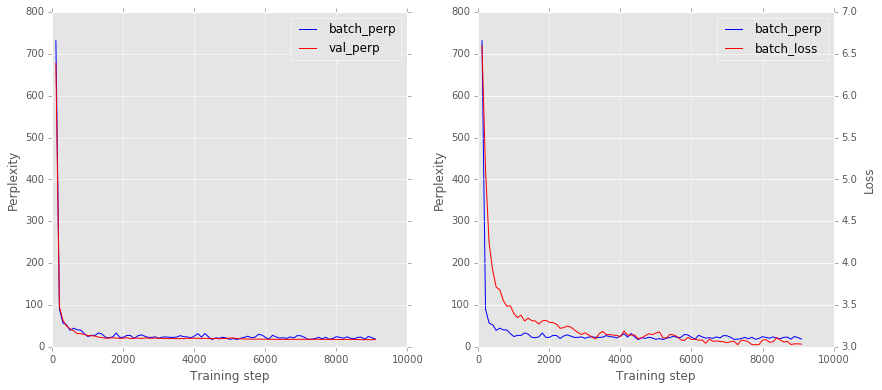

In [128]:
plot_log(loss_log, perp_log, val_perp_log)

#### Use negative sampling for sparse labels

In [129]:
## With embedding layer, no sparsity handling

num_nodes = 64
embedding_dim = 32
num_sampled = 64  # Number of negative examples to sample in softmax.

# Parameters:
# Embedding layer
embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_dim], -1.0, 1.0))
# Input gate: input, previous output, and bias.
ix = weight_init(embedding_dim, num_nodes)
im = weight_init(num_nodes, num_nodes)
ib = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx = weight_init(embedding_dim, num_nodes)
fm = weight_init(num_nodes, num_nodes)
fb = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx = weight_init(embedding_dim, num_nodes)
cm = weight_init(num_nodes, num_nodes)
cb = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox = weight_init(embedding_dim, num_nodes)
om = weight_init(num_nodes, num_nodes)
ob = bias_init(num_nodes)
# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
# Classifier weights and biases.
softmax_w = weight_init(vocabulary_size, num_nodes, np.sqrt(1.0/embedding_dim))
softmax_b = tf.Variable(tf.zeros([vocabulary_size]))
#w = weight_init(num_nodes, vocabulary_size)
#b = bias_init(vocabulary_size)

# Definition of the cell computation.
def lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    return output_gate * tf.tanh(state), state

# Input data.
train_data = list()
for _ in range(num_unrollings + 1):
    train_data.append( tf.placeholder(tf.int32, shape=[batch_size]) )
train_inputs = train_data[:-1]
train_labels = [tf.reshape(bch, [batch_size, 1]) for bch in train_data[1:]]

# Unrolled LSTM loop.
outputs = list()
output = saved_output
state = saved_state
embeds = [tf.nn.embedding_lookup(embeddings, bch) for bch in train_inputs]
for i in embeds:
    output, state = lstm_cell(i, output, state)
    outputs.append(output)

# State saving across unrollings.
with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    #logits = tf.matmul(tf.concat(0, outputs), w) + b
    #loss = tf.reduce_mean(
    #    tf.nn.softmax_cross_entropy_with_logits(
    #        logits, tf.concat(0, train_labels)))
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_w, softmax_b, tf.concat(0, outputs),
                                  tf.concat(0, train_labels), num_sampled, vocabulary_size))

# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
learning_rate = tf.train.exponential_decay(
    10.0, global_step, 5000, 0.1, staircase=True)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
#learning_rate = tf.train.exponential_decay(
#    0.001, global_step, 5000, 0.1, staircase=True)
#optimizer = tf.train.AdagradOptimizer(learning_rate)
#optimizer = tf.train.RMSPropOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)  

# Predictions.
logits = tf.matmul(tf.concat(0, outputs), tf.transpose(softmax_w)) + softmax_b
train_prediction = tf.nn.softmax(logits)

# Sampling and validation eval: batch 1, no unrolling.
sample_input = tf.placeholder(tf.int32)  # one sample character
sample_embed = tf.nn.embedding_lookup(embeddings, sample_input)
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
sample_output, sample_state = lstm_cell(
    sample_embed, saved_sample_output, saved_sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, tf.transpose(softmax_w)) + softmax_b)

In [130]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []
val_perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        batches = train_batches.next()
        feed_dict = dict()
        for i in range(num_unrollings + 1):
            feed_dict[train_data[i]] = batches[i]
        _, l, predictions, lr = session.run(
            [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f, learning rate: %f' % (step, mean_loss, lr))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate([batch2array(bch) for bch in batches[1:]])
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            if step % (summary_frequency * 10) == 0:
                # Generate some samples.
                print('=' * 100)
                for _ in range(5):
                    feed = sample(random_distribution())
                    sentence = characters(feed)[0]
                    reset_sample_state.run()
                    for _ in range(49):
                        prediction = sample_prediction.eval({sample_input: np.argmax(feed, 1)})
                        feed = sample(prediction)
                        sentence += characters(feed)[0]
                    print(sentence)
                print('=' * 100)
            
            # Measure validation set perplexity.
            reset_sample_state.run()
            valid_logprob = 0
            for _ in range(valid_size):
                b = valid_batches.next()
                predictions = sample_prediction.eval({sample_input: b[0]})
                valid_logprob = valid_logprob + logprob(predictions, batch2array(b[1]))
            val_perp = float(np.exp(valid_logprob / valid_size))
            print('Validation set perplexity: %.2f' % val_perp)
            val_perp_log.append(val_perp)

print('Elapsed training time:', time()-t0)

Initialized. Start training...
Average loss at step 0: 4.175362, learning rate: 10.000000
Minibatch perplexity: 728.89
oxfbykq bvxlpoosijegwzdxbadoltaiwj wljiedjfgkxpzn krpaleznvcgbuwxgyxlfclboqzfobpwliyvarpulnmbrbzufnv
whbgjnqpjonppeliovqjsc wmaadnefqurrpslztanzhqrwfdybcfwmbqgrgdaqaqfkquuijspbqnuhdgvcxlliphcvgur lqjhu
bfsrlouvtpmthyeeypyosnhzqlrwwngabltevuofbywbtmnta cxdyahqizluuwnabsbvztfpbhwnapynguvikffokcpkaueahmi
shtrocag tfgafiqjtxreioqnsavz nxzxxaqiip a hwx tceuftqanjmuvgiorcvbocscimkeqyycktmvjv bfbzeu oswjtou
wnhlpvqmpzorxpwvmoszkingrzppyfsthgynvhvlitzbwwpszrevcvns carn mgzogzsxaoglxv m jsxtpmydxegdnububafln
Validation set perplexity: 672.02
Average loss at step 100: 3.281267, learning rate: 10.000000
Minibatch perplexity: 212.77
Validation set perplexity: 224.14
Average loss at step 200: 2.625911, learning rate: 10.000000
Minibatch perplexity: 119.03
Validation set perplexity: 172.03
Average loss at step 300: 2.329196, learning rate: 10.000000
Minibatch perplexity: 103.43
Vali

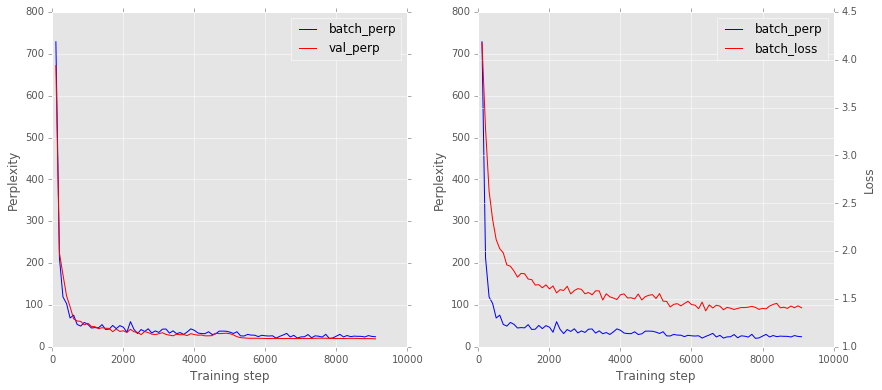

In [131]:
plot_log(loss_log, perp_log, val_perp_log)

---
Problem 3
---------

(difficult!)

Write a sequence-to-sequence LSTM which mirrors all the words in a sentence. For example, if your input is:

    the quick brown fox
    
the model should attempt to output:

    eht kciuq nworb xof
    
Refer to the lecture on how to put together a sequence-to-sequence model, as well as [this article](http://arxiv.org/abs/1409.3215) for best practices.

---

In [7]:
words = text.split()
len(words)

17005207

In [8]:
import collections
len(dict(collections.Counter(words[:20000])))

4290

In [9]:
import collections
len(dict(collections.Counter(words[:2000000])))

78382

In [10]:
len(' '.join(words[:20000]))

121723

In [11]:
len(' '.join(words[:2000000]))

11727979

In [12]:
## take part of data for training set, and let a sequence be composed of 4 words

# select former 2000000 words for training
nb_former = 2000000
trn_text = words[:nb_former]
trn_label_text = [w[::-1] for w in trn_text]
# set 4 words as a sequence chunk, thus there are 500000 sequences total
nb_words = 4
trn_text = [' '.join(trn_text[i*nb_words: i*nb_words+nb_words]) for i in range(nb_former//nb_words)]
trn_label_text = [' '.join(trn_label_text[i*nb_words: i*nb_words+nb_words]) for i in range(nb_former//nb_words)]

In [13]:
print(len(trn_text), len(trn_label_text))
print(len(trn_text[1]), trn_text[1])
print(len(trn_label_text[1]), trn_label_text[1])

500000 500000
19 term of abuse first
19 mret fo esuba tsrif


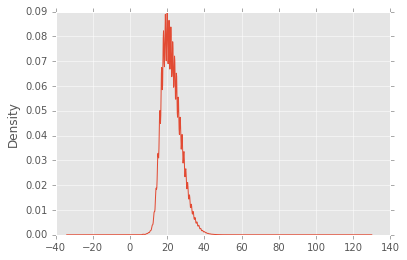

In [14]:
import pandas as pd
lens = map(len, trn_text)
pylab.style.use('ggplot')
pd.Series(lens).plot(kind='kde')

In [15]:
pd.Series(lens).describe()

count    500000.000000
mean         22.455960
std           5.196938
min           7.000000
25%          19.000000
50%          22.000000
75%          26.000000
max          89.000000
dtype: float64

In [16]:
## let only sequences with certain length feed the model

# filtering sequences with length outside 10-15
trn_filt_text = []
trn_label_filt_text = []
for i, seq in enumerate(trn_text):
    if len(seq) >= 10 and len(seq) <= 15:
        trn_filt_text.append(seq)
        trn_label_filt_text.append(trn_label_text[i])

In [17]:
len(trn_filt_text), len(trn_label_filt_text)

(29771, 29771)

In [18]:
chars = sorted(list(set(text)))
chars.append('END')
chars = ['PAD'] + chars
print(chars)

['PAD', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'END']


In [19]:
# id-char mapping
def id2char(idx): return chars[idx]
def char2id(c): return {c:i for i, c in enumerate(chars)}[c]
vocabulary_size = len(chars)
print(vocabulary_size)

29


In [20]:
def logprob(predictions, labels):
    """Log-probability of the true labels in a predicted batch."""
    predictions[predictions < 1e-10] = 1e-10  # avoid -log(p) prone to infinity
    return np.sum(labels * -np.log(predictions)) / labels.shape[0]

def sample(preds, temperature=0.7):
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    temp_preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(range(len(temp_preds)), p=temp_preds)

def onehot(idx, classes=vocabulary_size):
    return (idx==np.arange(classes)).astype('float32')

def weight_init(n_in, n_out, width=0.1):
    return tf.Variable(tf.truncated_normal([n_in, n_out], -width, width))

def bias_init(num_nodes):
    return tf.Variable(tf.zeros([1, num_nodes]))

In [21]:
# trn: sequence + padding (after reverse: padding + sequence)
# trn_label: sequence + END + padding (END to stop the generation)
trn = [np.asarray([onehot(char2id(c)) for c in seq]+[onehot(char2id('PAD')) for _ in range(15-len(seq))]) 
       for seq in trn_filt_text]
trn_label = [np.asarray([onehot(char2id(c)) for c in seq]+[onehot(char2id('END'))]+[onehot(char2id('PAD')) for _ in range(15-len(seq))]) 
             for seq in trn_label_filt_text]

In [22]:
trn[0].shape, trn_label[0].shape

((15, 29), (16, 29))

In [23]:
[char2id(c) for c in trn_filt_text[1]] + [char2id('PAD') for _ in range(15-len(trn_filt_text[1]))]

[3, 26, 1, 24, 9, 2, 21, 1, 10, 21, 1, 10, 20, 0, 0]

In [24]:
[char2id(c) for c in trn_label_filt_text[1]]+[char2id('END')]+[char2id('PAD') for _ in range(15-len(trn_label_filt_text[1]))]

[26, 3, 1, 21, 2, 9, 24, 1, 21, 10, 1, 20, 10, 28, 0, 0]

In [25]:
from sys import getsizeof
getsizeof(trn), getsizeof(trn_label)

(253640, 253640)

### One layer, no embedding (one-hot)

In [63]:
## No embedding layer
nb_unrolls = 15  # timesteps
num_nodes = 128
batch_size = 64

# Parameters:

# For encoder
# Input gate: input, previous output, and bias.
ix_enc = weight_init(vocabulary_size, num_nodes)
im_enc = weight_init(num_nodes, num_nodes)
ib_enc = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_enc = weight_init(vocabulary_size, num_nodes)
fm_enc = weight_init(num_nodes, num_nodes)
fb_enc = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_enc = weight_init(vocabulary_size, num_nodes)
cm_enc = weight_init(num_nodes, num_nodes)
cb_enc = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_enc = weight_init(vocabulary_size, num_nodes)
om_enc = weight_init(num_nodes, num_nodes)
ob_enc = bias_init(num_nodes)

# For decoder
# Input gate: input, previous output, and bias.
ix_dec = weight_init(vocabulary_size, num_nodes)
im_dec = weight_init(num_nodes, num_nodes)
ib_dec = bias_init(num_nodes)
# Forget gate: input, previous output, and bias.
fx_dec = weight_init(vocabulary_size, num_nodes)
fm_dec = weight_init(num_nodes, num_nodes)
fb_dec = bias_init(num_nodes)
# Memory cell: input, state and bias.                             
cx_dec = weight_init(vocabulary_size, num_nodes)
cm_dec = weight_init(num_nodes, num_nodes)
cb_dec = bias_init(num_nodes)
# Output gate: input, previous output, and bias.
ox_dec = weight_init(vocabulary_size, num_nodes)
om_dec = weight_init(num_nodes, num_nodes)
ob_dec = bias_init(num_nodes)

# Classifier weights and biases.
w = weight_init(num_nodes, vocabulary_size)
b = bias_init(vocabulary_size)

# Variables saving state across unrollings.
saved_output = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)
saved_state = tf.Variable(tf.zeros([batch_size, num_nodes]), trainable=False)


# Definition of the cell computation.
def enc_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_enc) + tf.matmul(o, im_enc) + ib_enc)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_enc) + tf.matmul(o, fm_enc) + fb_enc)
    update = tf.matmul(i, cx_enc) + tf.matmul(o, cm_enc) + cb_enc
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_enc) + tf.matmul(o, om_enc) + ob_enc)
    return output_gate * tf.tanh(state), state

def dec_lstm_cell(i, o, state):
    """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
    Note that in this formulation, we omit the various connections between the
    previous state and the gates."""
    input_gate = tf.sigmoid(tf.matmul(i, ix_dec) + tf.matmul(o, im_dec) + ib_dec)
    forget_gate = tf.sigmoid(tf.matmul(i, fx_dec) + tf.matmul(o, fm_dec) + fb_dec)
    update = tf.matmul(i, cx_dec) + tf.matmul(o, cm_dec) + cb_dec
    state = forget_gate * state + input_gate * tf.tanh(update)
    output_gate = tf.sigmoid(tf.matmul(i, ox_dec) + tf.matmul(o, om_dec) + ob_dec)
    return output_gate * tf.tanh(state), state


# Sequence END: as the start of the decoder
seq_end = tf.concat(0, [tf.constant(onehot([[char2id('END')]])) for i in range(batch_size)])

# Input data.
train_inputs = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(nb_unrolls)]
train_labels = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(nb_unrolls+1)]

# Unrolled Seq2Seq LSTM loop.
outputs = list()
output = saved_output
state = saved_state
# sequence 1: encoder
for inp in train_inputs:
    output, state = enc_lstm_cell(inp, output, state)

output, state = dec_lstm_cell(seq_end, output, state)
outputs.append(output)

# sequence 2: decoder
for inp in train_labels[:-1]:
    output, state = dec_lstm_cell(inp, output, state)
    outputs.append(output)


# State saving across unrollings.
#with tf.control_dependencies([saved_output.assign(output),
#                                saved_state.assign(state)]):
    # Classifier.
logits = tf.matmul(tf.concat(0, outputs), w) + b
loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            logits, tf.concat(0, train_labels)))

    
# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
optimizer = tf.train.AdamOptimizer(1e-3)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

# Predictions.
train_prediction = tf.nn.softmax(logits)

# Reset hidden states
#reset_state = tf.group(
#    saved_output.assign(tf.zeros([batch_size, num_nodes])),
#    saved_state.assign(tf.zeros([batch_size, num_nodes])))


## Sampling and validation
# one sample sequence
sample_inputs = [tf.placeholder(tf.float32, shape=[1, vocabulary_size]) for i in range(nb_unrolls)]
saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
sample_output = saved_sample_output
sample_state = saved_sample_state

# sequence 1 encoding
for inp in sample_inputs:
    sample_output, sample_state = enc_lstm_cell(inp, sample_output, sample_state)
sample_seq_end = tf.constant(onehot([[char2id('END')]]))
sample_output, sample_state = dec_lstm_cell(sample_seq_end, sample_output, sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                              saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.matmul(sample_output, w) + b)

# sequence 2 generation
sample_dec_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
sample_output = saved_sample_output
sample_state = saved_sample_state
sample_output, sample_state = dec_lstm_cell(sample_dec_input, sample_output, sample_state)
with tf.control_dependencies([saved_sample_output.assign(sample_output),
                              saved_sample_state.assign(sample_state)]):
    sample_generation = tf.nn.softmax(tf.matmul(sample_output, w) + b)

reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))

In [64]:
def generate(seed_sent, temperature=0.7):
    reset_sample_state.run()
    
    generated_len = len(seed_sent)
    inps = [onehot([[char2id(c)]]) for c in seed_sent[::-1]]
    feed_dict = {sample_inputs[i]: inp for i, inp in enumerate(inps)}
    pred = sample_prediction.eval(feed_dict)
    next_id = sample(pred[0])
    sentence = id2char(next_id)
    
    while len(sentence) < generated_len+2 and id2char(next_id)!='END':
        inp = onehot([[next_id]])
        feed_dict = {sample_dec_input: inp}
        pred = sample_generation.eval(feed_dict)
        next_id = sample(pred[0], temperature)
        sentence += id2char(next_id)
    
    return sentence

def index_generator(data_size):
    index = 0
    while True:
        yield index
        index = index + 1
        if index == data_size:
            index = 0

trn_idx = index_generator(len(trn)//batch_size)
trn_label_idx = index_generator(len(trn_label)//batch_size)

In [65]:
num_steps = 15001
summary_frequency = 100

loss_log = []
perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        #reset_state.run()
        # set feed dictionary
        inp_idx = trn_idx.next()
        inputs = np.stack(trn[batch_size*inp_idx: batch_size*inp_idx+batch_size])
        inputs = np.transpose(inputs, (1,0,2))[::-1]
        lab_idx = trn_label_idx.next()
        labels = np.stack(trn_label[batch_size*lab_idx: batch_size*lab_idx+batch_size])
        labels = np.transpose(labels, (1,0,2))
        feed_dict = {}
        for i in range(nb_unrolls):
            feed_dict[train_inputs[i]] = inputs[i]
            feed_dict[train_labels[i]] = labels[i]
        feed_dict[train_labels[-1]] = labels[-1]
        # run session
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f' % (step, mean_loss))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            #end_arr = np.concatenate([onehot([[char2id('END')]]) for i in range(batch_size)])[None, :]
            labels = np.concatenate(labels)
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            # Generate some samples to show.
            if step % (summary_frequency * 10) == 0:
                
                seed_sent = 'an apple a day '
                print('-' * 80)
                print("Seed sentence: %s" % seed_sent)
                
                for diversity in [0.7, 1.2]:
                    print('\n-- diversity:', diversity)
                    print('translation:', generate(seed_sent))
                
                print('-' * 80)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 3.372494
Minibatch perplexity: 29.15
--------------------------------------------------------------------------------
Seed sentence: an apple a day 

-- diversity: 0.7
translation: fqhqhEND

-- diversity: 1.2
translation: zianjfm mdrkqixxf
--------------------------------------------------------------------------------
Average loss at step 100: 3.249575
Minibatch perplexity: 22.72
Average loss at step 200: 2.794548
Minibatch perplexity: 13.41
Average loss at step 300: 2.502138
Minibatch perplexity: 11.87
Average loss at step 400: 2.383695
Minibatch perplexity: 10.73
Average loss at step 500: 2.175815
Minibatch perplexity: 7.81
Average loss at step 600: 1.963948
Minibatch perplexity: 7.02
Average loss at step 700: 1.835684
Minibatch perplexity: 5.18
Average loss at step 800: 1.787295
Minibatch perplexity: 6.51
Average loss at step 900: 1.746354
Minibatch perplexity: 4.68
Average loss at step 1000: 1.722478
Minibatch perplexity: 5.11

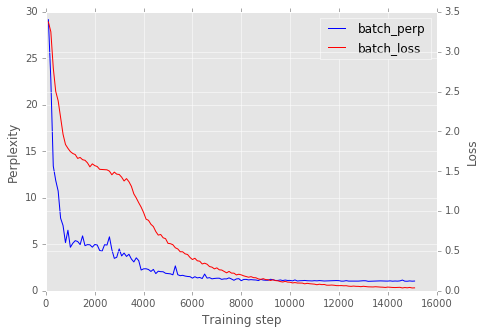

In [66]:
pylab.style.use('ggplot')
f, ax1 = pylab.subplots(1, 1, figsize=(7,5))
line1 = ax1.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='batch_perp')
ax1.set_xlabel('Training step')
ax1.set_ylabel('Perplexity')
ax2 = ax1.twinx()
line2 = ax2.plot(summary_frequency*(np.arange(len(loss_log))+1), loss_log, 'r-', label='batch_loss')
ax2.set_ylabel('Loss')
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

### With an encapsulated abstraction version

In [26]:
# LSTM cell
class LSTMcell(object):
    
    def __init__(self, input_dim, num_nodes):
        # Input gate: input, previous output, and bias.
        self.ix = weight_init(input_dim, num_nodes)
        self.im = weight_init(num_nodes, num_nodes)
        self.ib = bias_init(num_nodes)
        # Forget gate: input, previous output, and bias.
        self.fx = weight_init(input_dim, num_nodes)
        self.fm = weight_init(num_nodes, num_nodes)
        self.fb = bias_init(num_nodes)
        # Memory cell: input, state and bias.                             
        self.cx = weight_init(input_dim, num_nodes)
        self.cm = weight_init(num_nodes, num_nodes)
        self.cb = bias_init(num_nodes)
        # Output gate: input, previous output, and bias.
        self.ox = weight_init(input_dim, num_nodes)
        self.om = weight_init(num_nodes, num_nodes)
        self.ob = bias_init(num_nodes)
        # Variables saving state across unrollings.
        self.saved_output = tf.zeros([batch_size, num_nodes])
        self.saved_state = tf.zeros([batch_size, num_nodes])
        # Variables saving state for predict/generate phase.
        self.saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
        self.saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
        # Reset for-sample cell state
        self.reset_sample_state = tf.group(
            self.saved_sample_output.assign(tf.zeros([1, num_nodes])),
            self.saved_sample_state.assign(tf.zeros([1, num_nodes])))
    
    
    def memorize(self, i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, self.ix) + tf.matmul(o, self.im) + self.ib)
        forget_gate = tf.sigmoid(tf.matmul(i, self.fx) + tf.matmul(o, self.fm) + self.fb)
        update = tf.matmul(i, self.cx) + tf.matmul(o, self.cm) + self.cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, self.ox) + tf.matmul(o, self.om) + self.ob)
        
        return output_gate * tf.tanh(state), state
    
    
    def forward_pass(self, inputs):
        # Unrolled LSTM loop.
        self.outputs = list()
        output = self.saved_output
        state = self.saved_state
        # forward propagate into LSTM cells
        for inp in inputs:
            output, state = self.memorize(inp, output, state)
            self.outputs.append(output)
        self.saved_output = output
        self.saved_state = state
    
    
    def sample_forward_pass(self, sample_inputs):
        # Unrolled LSTM loop.
        self.sample_outputs = list()
        output = self.saved_sample_output
        state = self.saved_sample_state
        # forward propagate into LSTM cells for sample inputs
        for inp in sample_inputs:
            output, state = self.memorize(inp, output, state)
            self.sample_outputs.append(output)
        return output, state
        

    def predict(self, _input):
        return self.memorize(_input, self.saved_sample_output, self.saved_sample_state)

In [27]:
# softmax layer
class Softmax(object):
    
    def __init__(self, input_dim, labels):
        self.w = weight_init(input_dim, labels)
        self.b = bias_init(labels)
    
    def forward_pass(self, inputs):
        self.logits = tf.matmul(tf.concat(0, inputs), self.w) + self.b
    
    def predict(self, _input):
        return tf.nn.softmax(tf.matmul(_input, self.w) + self.b)

In [28]:
# LSTM net: input - LSTM_cell - softmax (or without softmax)
class LSTM_net(object):
    
    def __init__(self, layers):
        self.layers = layers
    
    def forwardPropagate(self, inputs, sample_case=False):
        self.output_per_layer, self.state_per_layer = [], []
        if sample_case:
            o, s = self.layers[0].sample_forward_pass(inputs)
            self.output_per_layer.append(o)
            self.state_per_layer.append(s)
            #for j in range(1, len(self.layers)):
            #    o, s = self.layers[j].sample_forward_pass(self.layers[j-1].outputs)
            #    self.output_per_layer.append(o)
            #    self.state_per_layer.append(s)
        else:
            self.layers[0].forward_pass(inputs)
            if type(self.layers[-1]) is Softmax:
            #    for j in range(1, len(self.layers)-1):
            #        self.layers[j].forward_pass(self.layers[j-1].outputs)
                self.layers[-1].forward_pass(self.layers[-2].outputs)
            #else:
            #    for j in range(1, len(self.layers)):
            #        self.layers[j].forward_pass(self.layers[j-1].outputs)
    
    def predict(self, _input):
        o, s = self.layers[0].predict(_input)
        #for j in range(1, len(self.layers)-1):
        #    with tf.control_dependencies([self.layers[j-1].saved_sample_output.assign(o),
        #                                  self.layers[j-1].saved_sample_state.assign(s)]):
        #        o, s = self.layers[j].predict(o)
        with tf.control_dependencies([self.layers[-2].saved_sample_output.assign(o),
                                      self.layers[-2].saved_sample_state.assign(s)]):
            return self.layers[-1].predict(o)
            
    def resetSampleState(self):
        if type(self.layers[-1]) is Softmax:
            for j in range(len(self.layers)-1):
                self.layers[j].reset_sample_state.run()
        else:
            for j in range(len(self.layers)):
                self.layers[j].reset_sample_state.run()

In [29]:
## No embedding, one layer
nb_unrolls = 15  # timesteps
num_nodes = 128
batch_size = 64


# Encoder & Decoder
encoder = LSTM_net([LSTMcell(vocabulary_size, num_nodes)])
decoder = LSTM_net([LSTMcell(vocabulary_size, num_nodes), 
                    Softmax(num_nodes, vocabulary_size)])

# Sequence END: as the start of the decoder
seq_end = tf.concat(0, [tf.constant(onehot([[char2id('END')]])) for i in range(batch_size)])

# Input data.
train_inputs = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(nb_unrolls)]
train_labels = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(nb_unrolls+1)]


# Unrolled Seq2Seq LSTM loop.
encoder.forwardPropagate(train_inputs)
#for j in range(len(decoder.layers)-1):
#    decoder.layers[j].saved_output = encoder.layers[j].saved_output
#    decoder.layers[j].saved_state = encoder.layers[j].saved_state
decoder.layers[0].saved_output = encoder.layers[0].saved_output
decoder.layers[0].saved_state = encoder.layers[0].saved_state
decoder.forwardPropagate([seq_end]+train_labels[:-1])


# Classifier.
logits = decoder.layers[-1].logits
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits, tf.concat(0, train_labels)))

    
# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
optimizer = tf.train.RMSPropOptimizer(1e-3)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

# Predictions.
train_prediction = tf.nn.softmax(logits)


## Sampling and validation
# one sample sequence
# sequence 1 encoding
sample_inputs = [tf.placeholder(tf.float32, shape=[1, vocabulary_size]) for i in range(nb_unrolls)]
encoder.forwardPropagate(sample_inputs, sample_case=True)
sample_seq_end = tf.constant(onehot([[char2id('END')]]))
#with tf.control_dependencies(
#    [decoder.layers[j].saved_sample_output.assign(encoder.output_per_layer[j]) for j in range(len(decoder.layers)-1)] + \
#    [decoder.layers[j].saved_sample_state.assign(encoder.state_per_layer[j]) for j in range(len(decoder.layers)-1)]):
with tf.control_dependencies([decoder.layers[0].saved_sample_output.assign(encoder.output_per_layer[0]),
                              decoder.layers[0].saved_sample_state.assign(encoder.state_per_layer[0])]):
    sample_prediction = decoder.predict(sample_seq_end)
# sequence 2 generation
sample_dec_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
sample_generation = decoder.predict(sample_dec_input)

In [30]:
def generate(seed_sent, temperature=0.7):
    generated_len = len(seed_sent)
    inps = [onehot([[char2id(c)]]) for c in seed_sent[::-1]]
    feed_dict = {sample_inputs[i]: inp for i, inp in enumerate(inps)}
    pred = sample_prediction.eval(feed_dict)
    next_id = sample(pred[0])
    sentence = id2char(next_id)
    
    while len(sentence) < generated_len+2 and id2char(next_id)!='END':
        inp = onehot([[next_id]])
        feed_dict = {sample_dec_input: inp}
        pred = sample_generation.eval(feed_dict)
        next_id = sample(pred[0], temperature)
        sentence += id2char(next_id)
    
    return sentence

def index_generator(data_size):
    index = 0
    while True:
        yield index
        index = index + 1
        if index == data_size:
            index = 0

trn_idx = index_generator(len(trn)//batch_size)
trn_label_idx = index_generator(len(trn_label)//batch_size)

In [31]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        # reset encoder state
        encoder.layers[0].saved_output = tf.zeros([batch_size, num_nodes])
        encoder.layers[0].saved_state = tf.zeros([batch_size, num_nodes])
        # set feed dictionary
        inp_idx = trn_idx.next()
        inputs = np.stack(trn[batch_size*inp_idx: batch_size*inp_idx+batch_size])
        inputs = np.transpose(inputs, (1,0,2))[::-1]
        lab_idx = trn_label_idx.next()
        labels = np.stack(trn_label[batch_size*lab_idx: batch_size*lab_idx+batch_size])
        labels = np.transpose(labels, (1,0,2))
        feed_dict = {}
        for i in range(nb_unrolls):
            feed_dict[train_inputs[i]] = inputs[i]
            feed_dict[train_labels[i]] = labels[i]
        feed_dict[train_labels[-1]] = labels[-1]
        # run session
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f' % (step, mean_loss))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(labels)
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            # Generate some samples to show.
            if step % (summary_frequency * 10) == 0:
                
                seed_sent = 'an apple a day '
                print('-' * 80)
                print("Seed sentence: %s" % seed_sent)
                
                for diversity in [0.7, 1.2]:
                    print('\n-- diversity:', diversity)
                    print('translation:', generate(seed_sent))
                
                print('-' * 80)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 3.367795
Minibatch perplexity: 29.01
--------------------------------------------------------------------------------
Seed sentence: an apple a day 

-- diversity: 0.7
translation: dolxktfhynuzcjbab

-- diversity: 1.2
translation: lomtPADxfsfnceain
--------------------------------------------------------------------------------
Average loss at step 100: 3.365453
Minibatch perplexity: 28.59
Average loss at step 200: 3.311615
Minibatch perplexity: 26.08
Average loss at step 300: 3.093755
Minibatch perplexity: 17.79
Average loss at step 400: 2.686857
Minibatch perplexity: 13.66
Average loss at step 500: 2.504370
Minibatch perplexity: 11.12
Average loss at step 600: 2.291323
Minibatch perplexity: 8.76
Average loss at step 700: 2.079060
Minibatch perplexity: 6.41
Average loss at step 800: 1.954761
Minibatch perplexity: 7.81
Average loss at step 900: 1.860286
Minibatch perplexity: 5.49
Average loss at step 1000: 1.746624
Minibatch perple

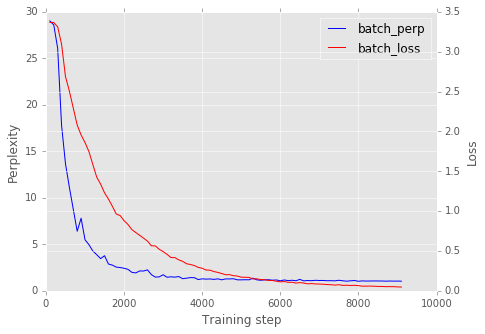

In [32]:
pylab.style.use('ggplot')
f, ax1 = pylab.subplots(1, 1, figsize=(7,5))
line1 = ax1.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='batch_perp')
ax1.set_xlabel('Training step')
ax1.set_ylabel('Perplexity')
ax2 = ax1.twinx()
line2 = ax2.plot(summary_frequency*(np.arange(len(loss_log))+1), loss_log, 'r-', label='batch_loss')
ax2.set_ylabel('Loss')
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

In [31]:
# add another sample
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        # reset encoder state
        encoder.layers[0].saved_output = tf.zeros([batch_size, num_nodes])
        encoder.layers[0].saved_state = tf.zeros([batch_size, num_nodes])
        # set feed dictionary
        inp_idx = trn_idx.next()
        inputs = np.stack(trn[batch_size*inp_idx: batch_size*inp_idx+batch_size])
        inputs = np.transpose(inputs, (1,0,2))[::-1]
        lab_idx = trn_label_idx.next()
        labels = np.stack(trn_label[batch_size*lab_idx: batch_size*lab_idx+batch_size])
        labels = np.transpose(labels, (1,0,2))
        feed_dict = {}
        for i in range(nb_unrolls):
            feed_dict[train_inputs[i]] = inputs[i]
            feed_dict[train_labels[i]] = labels[i]
        feed_dict[train_labels[-1]] = labels[-1]
        # run session
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f' % (step, mean_loss))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(labels)
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            # Generate some samples to show.
            if step % (summary_frequency * 10) == 0:
                
                print('-' * 80)
                seed_sent = 'an apple a day '
                print("Seed sentence: %s" % seed_sent)
                
                for diversity in [0.7, 1.2]:
                    print('\n-- diversity:', diversity)
                    print('translation:', generate(seed_sent))
                
                print('-' * 80)
                seed_sent = 'the quick brown'
                print("Seed sentence: %s" % seed_sent)
                
                for diversity in [0.7, 1.2]:
                    print('\n-- diversity:', diversity)
                    print('translation:', generate(seed_sent))
                
                print('-' * 80)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 3.372743
Minibatch perplexity: 29.16
--------------------------------------------------------------------------------
Seed sentence: an apple a day 

-- diversity: 0.7
translation: sentczm uszmfzhhl

-- diversity: 1.2
translation: yPADjcvEND
--------------------------------------------------------------------------------
Seed sentence: the quick brown

-- diversity: 0.7
translation: bEND

-- diversity: 1.2
translation: PADidcfqzbcPADoEND
--------------------------------------------------------------------------------
Average loss at step 100: 3.372384
Minibatch perplexity: 29.04
Average loss at step 200: 3.339497
Minibatch perplexity: 26.97
Average loss at step 300: 3.210283
Minibatch perplexity: 22.77
Average loss at step 400: 3.013943
Minibatch perplexity: 19.97
Average loss at step 500: 2.905651
Minibatch perplexity: 18.05
Average loss at step 600: 2.826141
Minibatch perplexity: 14.85
Average loss at step 700: 2.546241
Minibatch

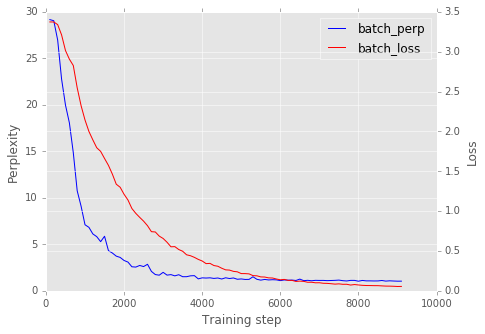

In [32]:
pylab.style.use('ggplot')
f, ax1 = pylab.subplots(1, 1, figsize=(7,5))
line1 = ax1.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='batch_perp')
ax1.set_xlabel('Training step')
ax1.set_ylabel('Perplexity')
ax2 = ax1.twinx()
line2 = ax2.plot(summary_frequency*(np.arange(len(loss_log))+1), loss_log, 'r-', label='batch_loss')
ax2.set_ylabel('Loss')
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

No embedding layer, Bi-directional encoder

In [29]:
## No embedding layer, Bi-directional encoder
nb_unrolls = 15  # timesteps
num_nodes = 128
batch_size = 64


# Encoder & Decoder
encoder = LSTM_net([LSTMcell(vocabulary_size, num_nodes)])
rev_encoder = LSTM_net([LSTMcell(vocabulary_size, num_nodes)])
decoder = LSTM_net([LSTMcell(vocabulary_size, num_nodes*2), 
                    Softmax(num_nodes*2, vocabulary_size)])

# Sequence END: as the start of the decoder
seq_end = tf.concat(0, [tf.constant(onehot([[char2id('END')]])) for i in range(batch_size)])

# Input data.
train_inputs = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(nb_unrolls)]
train_labels = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(nb_unrolls+1)]


# Unrolled Seq2Seq LSTM loop.
encoder.forwardPropagate(train_inputs)
rev_encoder.forwardPropagate(train_inputs[::-1])
#for j in range(len(decoder.layers)-1):
#    decoder.layers[j].saved_output = encoder.layers[j].saved_output
#    decoder.layers[j].saved_state = encoder.layers[j].saved_state
decoder.layers[0].saved_output = tf.concat(1, [encoder.layers[0].saved_output, rev_encoder.layers[0].saved_output])
decoder.layers[0].saved_state = tf.concat(1, [encoder.layers[0].saved_state, rev_encoder.layers[0].saved_state])
decoder.forwardPropagate([seq_end]+train_labels[:-1])


# Classifier.
logits = decoder.layers[-1].logits
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits, tf.concat(0, train_labels)))

    
# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
optimizer = tf.train.RMSPropOptimizer(1e-3)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

# Predictions.
train_prediction = tf.nn.softmax(logits)


## Sampling and validation
# one sample sequence
# sequence 1 encoding
sample_inputs = [tf.placeholder(tf.float32, shape=[1, vocabulary_size]) for i in range(nb_unrolls)]
encoder.forwardPropagate(sample_inputs, sample_case=True)
rev_encoder.forwardPropagate(sample_inputs[::-1], sample_case=True)
sample_seq_end = tf.constant(onehot([[char2id('END')]]))
#with tf.control_dependencies(
#    [decoder.layers[j].saved_sample_output.assign(encoder.output_per_layer[j]) for j in range(len(decoder.layers)-1)] + \
#    [decoder.layers[j].saved_sample_state.assign(encoder.state_per_layer[j]) for j in range(len(decoder.layers)-1)]):
with tf.control_dependencies([
    decoder.layers[0].saved_sample_output.assign(
        tf.concat(1, [encoder.output_per_layer[0], rev_encoder.output_per_layer[0]])), 
    decoder.layers[0].saved_sample_state.assign(
        tf.concat(1, [encoder.state_per_layer[0], rev_encoder.state_per_layer[0]]))]):
    sample_prediction = decoder.predict(sample_seq_end)
# sequence 2 generation
sample_dec_input = tf.placeholder(tf.float32, shape=[1, vocabulary_size])
sample_generation = decoder.predict(sample_dec_input)

In [30]:
def generate(seed_sent, temperature=0.7):
    generated_len = len(seed_sent)
    inps = [onehot([[char2id(c)]]) for c in seed_sent[::-1]]
    feed_dict = {sample_inputs[i]: inp for i, inp in enumerate(inps)}
    pred = sample_prediction.eval(feed_dict)
    next_id = sample(pred[0])
    sentence = id2char(next_id)
    
    while len(sentence) < generated_len+2 and id2char(next_id)!='END':
        inp = onehot([[next_id]])
        feed_dict = {sample_dec_input: inp}
        pred = sample_generation.eval(feed_dict)
        next_id = sample(pred[0], temperature)
        sentence += id2char(next_id)
    
    return sentence

def index_generator(data_size):
    index = 0
    while True:
        yield index
        index = index + 1
        if index == data_size:
            index = 0

trn_idx = index_generator(len(trn)//batch_size)
trn_label_idx = index_generator(len(trn_label)//batch_size)

In [31]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        # reset encoder state
        encoder.layers[0].saved_output = tf.zeros([batch_size, num_nodes])
        encoder.layers[0].saved_state = tf.zeros([batch_size, num_nodes])
        # set feed dictionary
        inp_idx = trn_idx.next()
        inputs = np.stack(trn[batch_size*inp_idx: batch_size*inp_idx+batch_size])
        inputs = np.transpose(inputs, (1,0,2))[::-1]
        lab_idx = trn_label_idx.next()
        labels = np.stack(trn_label[batch_size*lab_idx: batch_size*lab_idx+batch_size])
        labels = np.transpose(labels, (1,0,2))
        feed_dict = {}
        for i in range(nb_unrolls):
            feed_dict[train_inputs[i]] = inputs[i]
            feed_dict[train_labels[i]] = labels[i]
        feed_dict[train_labels[-1]] = labels[-1]
        # run session
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f' % (step, mean_loss))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(labels)
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            # Generate some samples to show.
            if step % (summary_frequency * 10) == 0:
                
                seed_sent = 'an apple a day '
                print('-' * 80)
                print("Seed sentence: %s" % seed_sent)
                
                for diversity in [0.7, 1.2]:
                    print('\n-- diversity:', diversity)
                    print('translation:', generate(seed_sent))
                
                print('-' * 80)
                seed_sent = 'the quick brown'
                print("Seed sentence: %s" % seed_sent)
                
                for diversity in [0.7, 1.2]:
                    print('\n-- diversity:', diversity)
                    print('translation:', generate(seed_sent))
                
                print('-' * 80)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 3.396659
Minibatch perplexity: 29.86
--------------------------------------------------------------------------------
Seed sentence: an apple a day 

-- diversity: 0.7
translation: owvhfrqiwPADjmprc

-- diversity: 1.2
translation: aqxxmhimlafkPADgPAD
--------------------------------------------------------------------------------
Seed sentence: the quick brown

-- diversity: 0.7
translation: xdmmPADilbyqhzawj

-- diversity: 1.2
translation: ngjypsejxPADg  tt
--------------------------------------------------------------------------------
Average loss at step 100: 3.388599
Minibatch perplexity: 28.87
Average loss at step 200: 3.274526
Minibatch perplexity: 24.76
Average loss at step 300: 3.164894
Minibatch perplexity: 22.47
Average loss at step 400: 3.055782
Minibatch perplexity: 19.97
Average loss at step 500: 2.883129
Minibatch perplexity: 16.68
Average loss at step 600: 2.739679
Minibatch perplexity: 14.55
Average loss at step 70

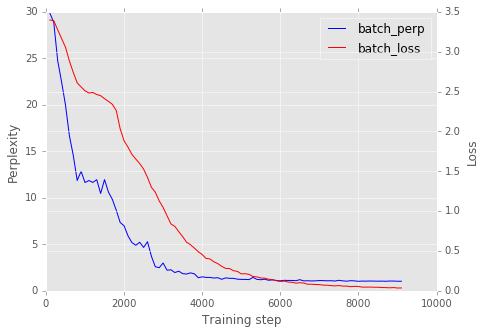

In [32]:
pylab.style.use('ggplot')
f, ax1 = pylab.subplots(1, 1, figsize=(7,5))
line1 = ax1.plot(summary_frequency*(np.arange(len(perp_log))+1), perp_log, 'b-', label='batch_perp')
ax1.set_xlabel('Training step')
ax1.set_ylabel('Perplexity')
ax2 = ax1.twinx()
line2 = ax2.plot(summary_frequency*(np.arange(len(loss_log))+1), loss_log, 'r-', label='batch_loss')
ax2.set_ylabel('Loss')
lines = line1 + line2
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

Issues to solve as developing <b>multi-layers</b>:
1. Cannot use control_dependencies to pass sample_output/sample_state in generating step module.
2. If change the initialization of sample states with tf.zeros rather than tf.Variable, will cause InvalidArgumentError as the following codes (wierd).

In [37]:
# LSTM cell
class LSTMcell(object):
    
    def __init__(self, input_dim, num_nodes):
        # Input gate: input, previous output, and bias.
        self.ix = weight_init(input_dim, num_nodes)
        self.im = weight_init(num_nodes, num_nodes)
        self.ib = bias_init(num_nodes)
        # Forget gate: input, previous output, and bias.
        self.fx = weight_init(input_dim, num_nodes)
        self.fm = weight_init(num_nodes, num_nodes)
        self.fb = bias_init(num_nodes)
        # Memory cell: input, state and bias.                             
        self.cx = weight_init(input_dim, num_nodes)
        self.cm = weight_init(num_nodes, num_nodes)
        self.cb = bias_init(num_nodes)
        # Output gate: input, previous output, and bias.
        self.ox = weight_init(input_dim, num_nodes)
        self.om = weight_init(num_nodes, num_nodes)
        self.ob = bias_init(num_nodes)
        # Variables saving state across unrollings.
        self.saved_output = tf.zeros([batch_size, num_nodes])
        self.saved_state = tf.zeros([batch_size, num_nodes])
        # Variables saving state for predict/generate phase.
        self.saved_sample_output = tf.zeros([1, num_nodes])
        self.saved_sample_state = tf.zeros([1, num_nodes])
    
    
    def memorize(self, i, o, state):
        """Create a LSTM cell. See e.g.: http://arxiv.org/pdf/1402.1128v1.pdf
        Note that in this formulation, we omit the various connections between the
        previous state and the gates."""
        input_gate = tf.sigmoid(tf.matmul(i, self.ix) + tf.matmul(o, self.im) + self.ib)
        forget_gate = tf.sigmoid(tf.matmul(i, self.fx) + tf.matmul(o, self.fm) + self.fb)
        update = tf.matmul(i, self.cx) + tf.matmul(o, self.cm) + self.cb
        state = forget_gate * state + input_gate * tf.tanh(update)
        output_gate = tf.sigmoid(tf.matmul(i, self.ox) + tf.matmul(o, self.om) + self.ob)
        
        return output_gate * tf.tanh(state), state
    
    
    def forward_pass(self, inputs):
        # Unrolled LSTM loop.
        self.outputs = list()
        output = self.saved_output
        state = self.saved_state
        # forward propagate into LSTM cells
        for inp in inputs:
            output, state = self.memorize(inp, output, state)
            self.outputs.append(output)
        self.saved_output = output
        self.saved_state = state
    
    
    def sample_forward_pass(self, sample_inputs):
        # Unrolled LSTM loop.
        self.sample_outputs = list()
        output = self.saved_sample_output
        state = self.saved_sample_state
        # forward propagate into LSTM cells for sample inputs
        for inp in sample_inputs:
            output, state = self.memorize(inp, output, state)
            self.sample_outputs.append(output)
        return output, state
        

    def predict(self, _input):
        return self.memorize(_input, self.saved_sample_output, self.saved_sample_state)

In [38]:
# LSTM net: input - LSTM_cell - softmax (or without softmax)
class LSTM_net(object):
    
    def __init__(self, layers):
        self.layers = layers
    
    def forwardPropagate(self, inputs, sample_case=False):
        self.output_per_layer, self.state_per_layer = [], []
        if sample_case:
            o, s = self.layers[0].sample_forward_pass(inputs)
            self.output_per_layer.append(o)
            self.state_per_layer.append(s)
            for j in range(1, len(self.layers)):
                o, s = self.layers[j].sample_forward_pass(self.layers[j-1].outputs)
                self.output_per_layer.append(o)
                self.state_per_layer.append(s)
        else:
            self.layers[0].forward_pass(inputs)
            if type(self.layers[-1]) is Softmax:
                for j in range(1, len(self.layers)-1):
                    self.layers[j].forward_pass(self.layers[j-1].outputs)
                self.layers[-1].forward_pass(self.layers[-2].outputs)
            else:
                for j in range(1, len(self.layers)):
                    self.layers[j].forward_pass(self.layers[j-1].outputs)
    
    def predict(self, _input):
        o, s = self.layers[0].predict(_input)
        self.layers[0].saved_sample_output = o
        self.layers[0].saved_sample_state = s
        for j in range(1, len(self.layers)-1):
            o, s = self.layers[j].predict(o)
            self.layers[j].saved_sample_output = o
            self.layers[j].saved_sample_state = s
        return self.layers[-1].predict(o)
            
    def resetSampleState(self):
        if type(self.layers[-1]) is Softmax:
            for j in range(len(self.layers)-1):
                self.layers[j].reset_sample_state.run()
        else:
            for j in range(len(self.layers)):
                self.layers[j].reset_sample_state.run()

In [52]:
## No embedding layer
nb_unrolls = 15  # timesteps
num_nodes = 128
batch_size = 64


# Encoder & Decoder
encoder = LSTM_net([LSTMcell(vocabulary_size, num_nodes)])
#rev_encoder = LSTM_net([LSTMcell(vocabulary_size, num_nodes)])
decoder = LSTM_net([LSTMcell(vocabulary_size, num_nodes), 
                    Softmax(num_nodes, vocabulary_size)])

# Sequence END: as the start of the decoder
seq_end = tf.concat(0, [tf.constant(onehot([[char2id('END')]])) for i in range(batch_size)])

# Input data.
train_inputs = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(nb_unrolls)]
train_labels = [tf.placeholder(tf.float32, shape=[batch_size, vocabulary_size]) for _ in range(nb_unrolls+1)]


# Unrolled Seq2Seq LSTM loop.
encoder.forwardPropagate(train_inputs)
#for j in range(len(decoder.layers)-1):
#    decoder.layers[j].saved_output = encoder.layers[j].saved_output
#    decoder.layers[j].saved_state = encoder.layers[j].saved_state
decoder.layers[0].saved_output = encoder.layers[0].saved_output
decoder.layers[0].saved_state = encoder.layers[0].saved_state
decoder.forwardPropagate([seq_end]+train_labels[:-1])


# Classifier.
logits = decoder.layers[-1].logits
loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        logits, tf.concat(0, train_labels)))

    
# Optimizer.
# note: 
#   tf.train.optimizer.minimize() same as 
#   tf.train.optimizer.compute_gradients() > tf.train.optimizer.apply_gradients()
global_step = tf.Variable(0)
optimizer = tf.train.RMSPropOptimizer(1e-3)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 1.25)  # clip gradients
optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

# Predictions.
train_prediction = tf.nn.softmax(logits)


## Sampling and validation
# one sample sequence
# sequence 1 encoding
sample_inputs = [tf.placeholder(tf.float32, shape=[1, vocabulary_size]) for i in range(nb_unrolls)]
encoder.forwardPropagate(sample_inputs, sample_case=True)
sample_seq_end = tf.constant(onehot([[char2id('END')]]))
#with tf.control_dependencies(
#    [decoder.layers[j].saved_sample_output.assign(encoder.output_per_layer[j]) for j in range(len(decoder.layers)-1)] + \
#    [decoder.layers[j].saved_sample_state.assign(encoder.state_per_layer[j]) for j in range(len(decoder.layers)-1)]):
#with tf.control_dependencies([decoder.layers[0].saved_sample_output.assign(encoder.output_per_layer[0]),
#                              decoder.layers[0].saved_sample_state.assign(encoder.state_per_layer[0])]):
decoder.layers[0].saved_sample_output = encoder.output_per_layer[0]
decoder.layers[0].saved_sample_state = encoder.state_per_layer[0]
sample_prediction = decoder.predict(sample_seq_end)
# sequence 2 generation
sample_dec_input = tf.placeholder('float32', shape=[1, vocabulary_size])
sample_generation = decoder.predict(sample_dec_input)

In [54]:
def generate(seed_sent, temperature=0.7):
    generated_len = len(seed_sent)
    inps = [onehot([[char2id(c)]]) for c in seed_sent[::-1]]
    feed_dict = {sample_inputs[i]: inp for i, inp in enumerate(inps)}
    pred = sample_prediction.eval(feed_dict)
    next_id = sample(pred[0])
    sentence = id2char(next_id)
    
    while len(sentence) < generated_len+2 and id2char(next_id)!='END':
        inp = onehot([[next_id]])
        print(sentence)
        print('Shape of inp:', inp.shape)
        print('Type of inp:', inp.dtype)
        feed_dict = {sample_dec_input: inp}
        pred = sample_generation.eval(feed_dict)
        next_id = sample(pred[0], temperature)
        sentence += id2char(next_id)
    
    return sentence

def index_generator(data_size):
    index = 0
    while True:
        yield index
        index = index + 1
        if index == data_size:
            index = 0

trn_idx = index_generator(len(trn)//batch_size)
trn_label_idx = index_generator(len(trn_label)//batch_size)

In [55]:
num_steps = 9001
summary_frequency = 100

loss_log = []
perp_log = []

t0 = time()
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print('Initialized. Start training...')
    mean_loss = 0
    for step in range(num_steps):
        # reset encoder state
        encoder.layers[0].saved_output = tf.zeros([batch_size, num_nodes])
        encoder.layers[0].saved_state = tf.zeros([batch_size, num_nodes])
        # set feed dictionary
        inp_idx = trn_idx.next()
        inputs = np.stack(trn[batch_size*inp_idx: batch_size*inp_idx+batch_size])
        inputs = np.transpose(inputs, (1,0,2))[::-1]
        lab_idx = trn_label_idx.next()
        labels = np.stack(trn_label[batch_size*lab_idx: batch_size*lab_idx+batch_size])
        labels = np.transpose(labels, (1,0,2))
        feed_dict = {}
        for i in range(nb_unrolls):
            feed_dict[train_inputs[i]] = inputs[i]
            feed_dict[train_labels[i]] = labels[i]
        feed_dict[train_labels[-1]] = labels[-1]
        # run session
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        mean_loss += l
        # verbose to monitor training
        if step % summary_frequency == 0:
            if step > 0:
                mean_loss = mean_loss / summary_frequency
            # The mean loss is an estimate of the loss over the last few batches.
            print('Average loss at step %d: %f' % (step, mean_loss))
            loss_log.append(mean_loss)
            mean_loss = 0
            
            labels = np.concatenate(labels)
            perp = float(np.exp(logprob(predictions, labels)))
            print('Minibatch perplexity: %.2f' % perp)
            perp_log.append(perp)
            
            # Generate some samples to show.
            if step % (summary_frequency * 10) == 0:
                
                seed_sent = 'an apple a day '
                print('-' * 80)
                print("Seed sentence: %s" % seed_sent)
                
                for diversity in [0.7, 1.2]:
                    print('\n-- diversity:', diversity)
                    print('translation:', generate(seed_sent))
                
                print('-' * 80)

print('Elapsed training time: %.3f seconds.' %(time()-t0))

Initialized. Start training...
Average loss at step 0: 3.364893
Minibatch perplexity: 28.93
--------------------------------------------------------------------------------
Seed sentence: an apple a day 

-- diversity: 0.7
q
Shape of inp: (1, 29)
Type of inp: float32


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_172' with dtype float and shape [1,29]
	 [[Node: Placeholder_172 = Placeholder[dtype=DT_FLOAT, shape=[1,29], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'Placeholder_172', defined at:
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-52-14ede60e0ff0>", line 56, in <module>
    sample_inputs = [tf.placeholder(tf.float32, shape=[1, vocabulary_size]) for i in range(nb_unrolls)]
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1332, in placeholder
    name=name)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 1748, in _placeholder
    name=name)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 749, in apply_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2380, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1298, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_172' with dtype float and shape [1,29]
	 [[Node: Placeholder_172 = Placeholder[dtype=DT_FLOAT, shape=[1,29], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]
